In [ ]:
import torch
import cv2
import torchvision
import numpy as np
from torchvision import models

# def load_model():
#     # Load the DeepLab v3 model to system
#     device = "cuda" if torch.cuda.is_available() else "cpu"
#     model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True)
#     model.to(device).eval()
#     return model

def get_model():
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    print(device)
    model = models.segmentation.deeplabv3_resnet101(pretrained=True).to(device).eval()
    return model

In [ ]:
def get_pred(img, model):
  # See if GPU is available and if yes, use it
  device = "cuda:0" if torch.cuda.is_available() else "cpu"

  # Define the standard transforms that need to be done at inference time
  imagenet_stats = [[0.485, 0.456, 0.406], [0.485, 0.456, 0.406]]
  preprocess = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize(mean = imagenet_stats[0],
                                                                                std  = imagenet_stats[1])])
  
  # we unsqueeze the image so that it becomes [1 x C x H x W] from [C x H x W]
  input_tensor = preprocess(img).unsqueeze(0)
  input_tensor = input_tensor.to(device)

  # Make the predictions for labels across the image
  with torch.no_grad():
      output = model(input_tensor)["out"][0]
      output = output.argmax(0)

  # Return the predictions
  return output.cpu().numpy()

cuda:0


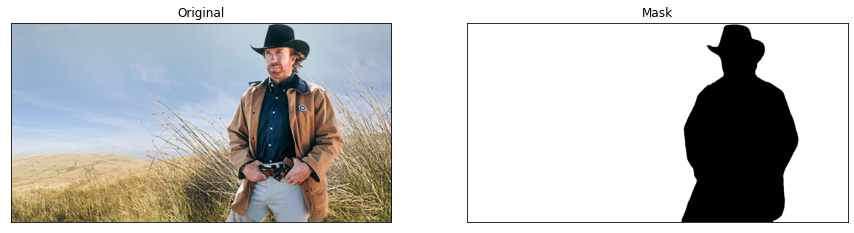

In [ ]:
import matplotlib.pyplot as plt
# from utils import grab_frame

# Define two axes for showing the mask and the true video in realtime
# And set the ticks to none for both the axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 8))
ax1.set_title("Original")
ax2.set_title("Mask")

ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])

img = cv2.imread('chuck-1200x628.jpg')
model = get_model()
labels = get_pred(img, model)

# Wherever there's empty space/no person, the label is zero 
# Hence identify such areas and create a mask (replicate it across RGB channels)
mask = labels == 0
mask = np.repeat(mask[:, :, np.newaxis], 3, axis = 2)

# Create two image objects to picture on top of the axes defined above
im1 = ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
im2 = ax2.imshow(mask * 255)

# Switch on the interactive mode in matplotlib
plt.ion()
plt.show()

cuda:0


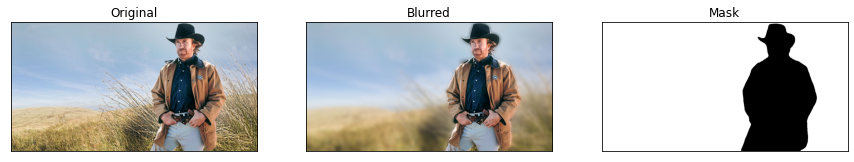

In [ ]:
img = cv2.imread('chuck-1200x628.jpg')
# Read the frame's width, height, channels and get the labels' predictions from utilities
width, height, channels = img.shape

model = get_model()
labels = get_pred(img, model)

# Wherever there's empty space/no person, the label is zero 
# Hence identify such areas and create a mask (replicate it across RGB channels)
mask = labels == 0
mask = np.repeat(mask[:, :, np.newaxis], channels, axis = 2)

# Define the kernel size for applying Gaussian Blur
blur_value = (51, 51)
# Apply the Gaussian blur for background with the kernel size specified in constants above
blur = cv2.GaussianBlur(img, blur_value, 0)
img[mask] = blur[mask]

# Set the data of the two images to frame and mask values respectively

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 8))
ax1.set_title("Original")
ax2.set_title("Blurred")
ax3.set_title("Mask")

original  = cv2.imread('chuck-1200x628.jpg')
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])

# Create two image objects to picture on top of the axes defined above

im1 = ax1.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
im2 = ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
im3 = ax3.imshow(mask * 255)

plt.ion()
plt.show()

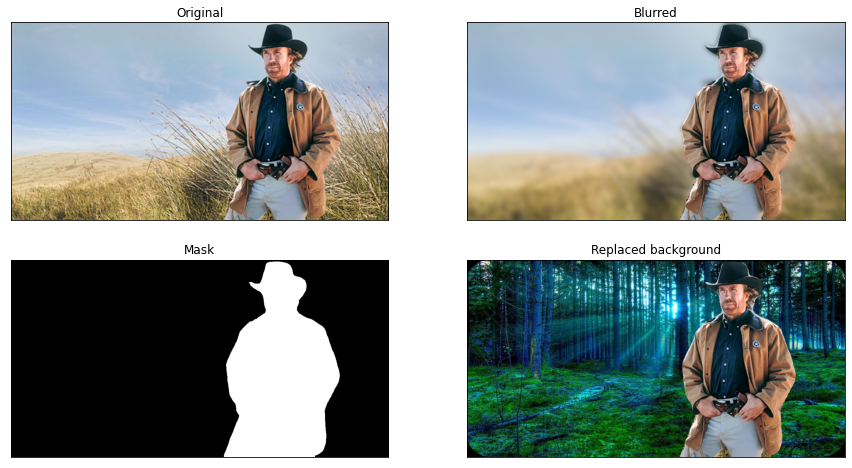

In [ ]:
# Read the background image to memory
frame = cv2.imread('chuck-1200x628.jpg')
bg_image = cv2.imread('forest.png')
bg_image = cv2.cvtColor(bg_image, cv2.COLOR_BGR2RGB)

# Read frame from the video capture object and get the labels from get_pred function
width, height, channels = frame.shape
labels = get_pred(frame, model)

# Wherever there's empty space/no person, the label is zero 
# Hence identify such areas and create a mask (replicate it across RGB channels)
mask = labels == 0
mask = np.repeat(mask[:, :, np.newaxis], channels, axis = 2)

# Define a blurring value kernel size for cv2's Gaussian Blur
img = cv2.imread('chuck-1200x628.jpg')
blur_value = (51, 51)
blur = cv2.GaussianBlur(img, blur_value, 0)
img[mask] = blur[mask]

# The PASCAL VOC dataset has 20 categories of which Person is the 16th category
# Hence wherever person is predicted, the label returned will be 15
# Subsequently repeat the mask across RGB channels 
mask = labels == 15
mask = np.repeat(mask[:, :, np.newaxis], 3, axis = 2)

# Resize the image as per the frame capture size
bg = cv2.resize(bg_image, (height, width))
bg[mask] = frame[mask]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (15, 8))
ax1.set_title("Original")
ax2.set_title("Blurred")
ax3.set_title("Mask")
ax4.set_title("Replaced background")


ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])
ax4.set_xticks([])
ax4.set_yticks([])

# Show the images

im1 = ax1.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
im2 = ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
im3 = ax3.imshow(mask * 255)
im4 = ax4.imshow(cv2.cvtColor(bg, cv2.COLOR_BGR2RGB))

plt.ion()
plt.show()